In [1]:
import pandas
import numpy
from matplotlib import pyplot
import os
import ROOT

Welcome to JupyROOT 6.26/04


In [2]:
df = pandas.read_csv("slurm_distrdf_lhcb_ttree_5Jwb3QSx.csv")
df

,files,nodes,cores,partitions,time,iteration
0,1200,7,16,112,134.262602,0
1,1200,7,16,112,95.760213,1
2,1200,7,16,112,93.657029,2
3,1200,7,16,112,97.322567,3
4,1200,7,16,112,95.446113,4
5,1200,6,16,96,110.299855,0
6,1200,6,16,96,106.322408,1
7,1200,6,16,96,103.584202,2
8,1200,6,16,96,105.811145,3
9,1200,6,16,96,105.064764,4


In [3]:
size_1file_uncompressed = 1576598472
size_1file_zstd = 1063156315

dataset_size_GB = size_1file_zstd * df.files[0] / 1e9

cols = {
    "nodes": [],
    "cores": [],
    "time": [],
    "std": [],
    "throughput_GB_s": [],
    "throughput_speedup": [],
}

for label, group in df.groupby("nodes"):
    firstrow = group.iloc[0]
    cores = firstrow.cores
    nodes = firstrow.nodes
    times =  group.iloc[1:].time
    mean = times.mean()
    stdev = numpy.std(times)
    cols["cores"].append(cores*nodes)
    cols["nodes"].append(nodes)
    cols["time"].append(mean)
    cols["std"].append(stdev)
    cols["throughput_GB_s"].append(dataset_size_GB/mean)
    cols["throughput_speedup"].append(cols["throughput_GB_s"][-1]/cols["throughput_GB_s"][0])

timesdf = pandas.DataFrame(cols)
timesdf

,nodes,cores,time,std,throughput_GB_s,throughput_speedup
0,1.0,16.0,594.808721,4.373597,2.144870,1.000000
1,2.0,32.0,304.769560,0.661926,4.186073,1.951667
2,3.0,48.0,202.948233,0.872255,6.286271,2.930840
3,4.0,64.0,152.860374,0.498777,8.346097,3.891190
4,5.0,80.0,123.301211,1.780078,10.346918,4.824030
5,6.0,96.0,105.195630,1.032269,12.127762,5.654310
6,7.0,112.0,95.546480,1.301947,13.352533,6.225334


# TGraph

Info in <TCanvas::Print>: png file distrdf_lustre_lhcb_multinode_processingthroughput.png has been created


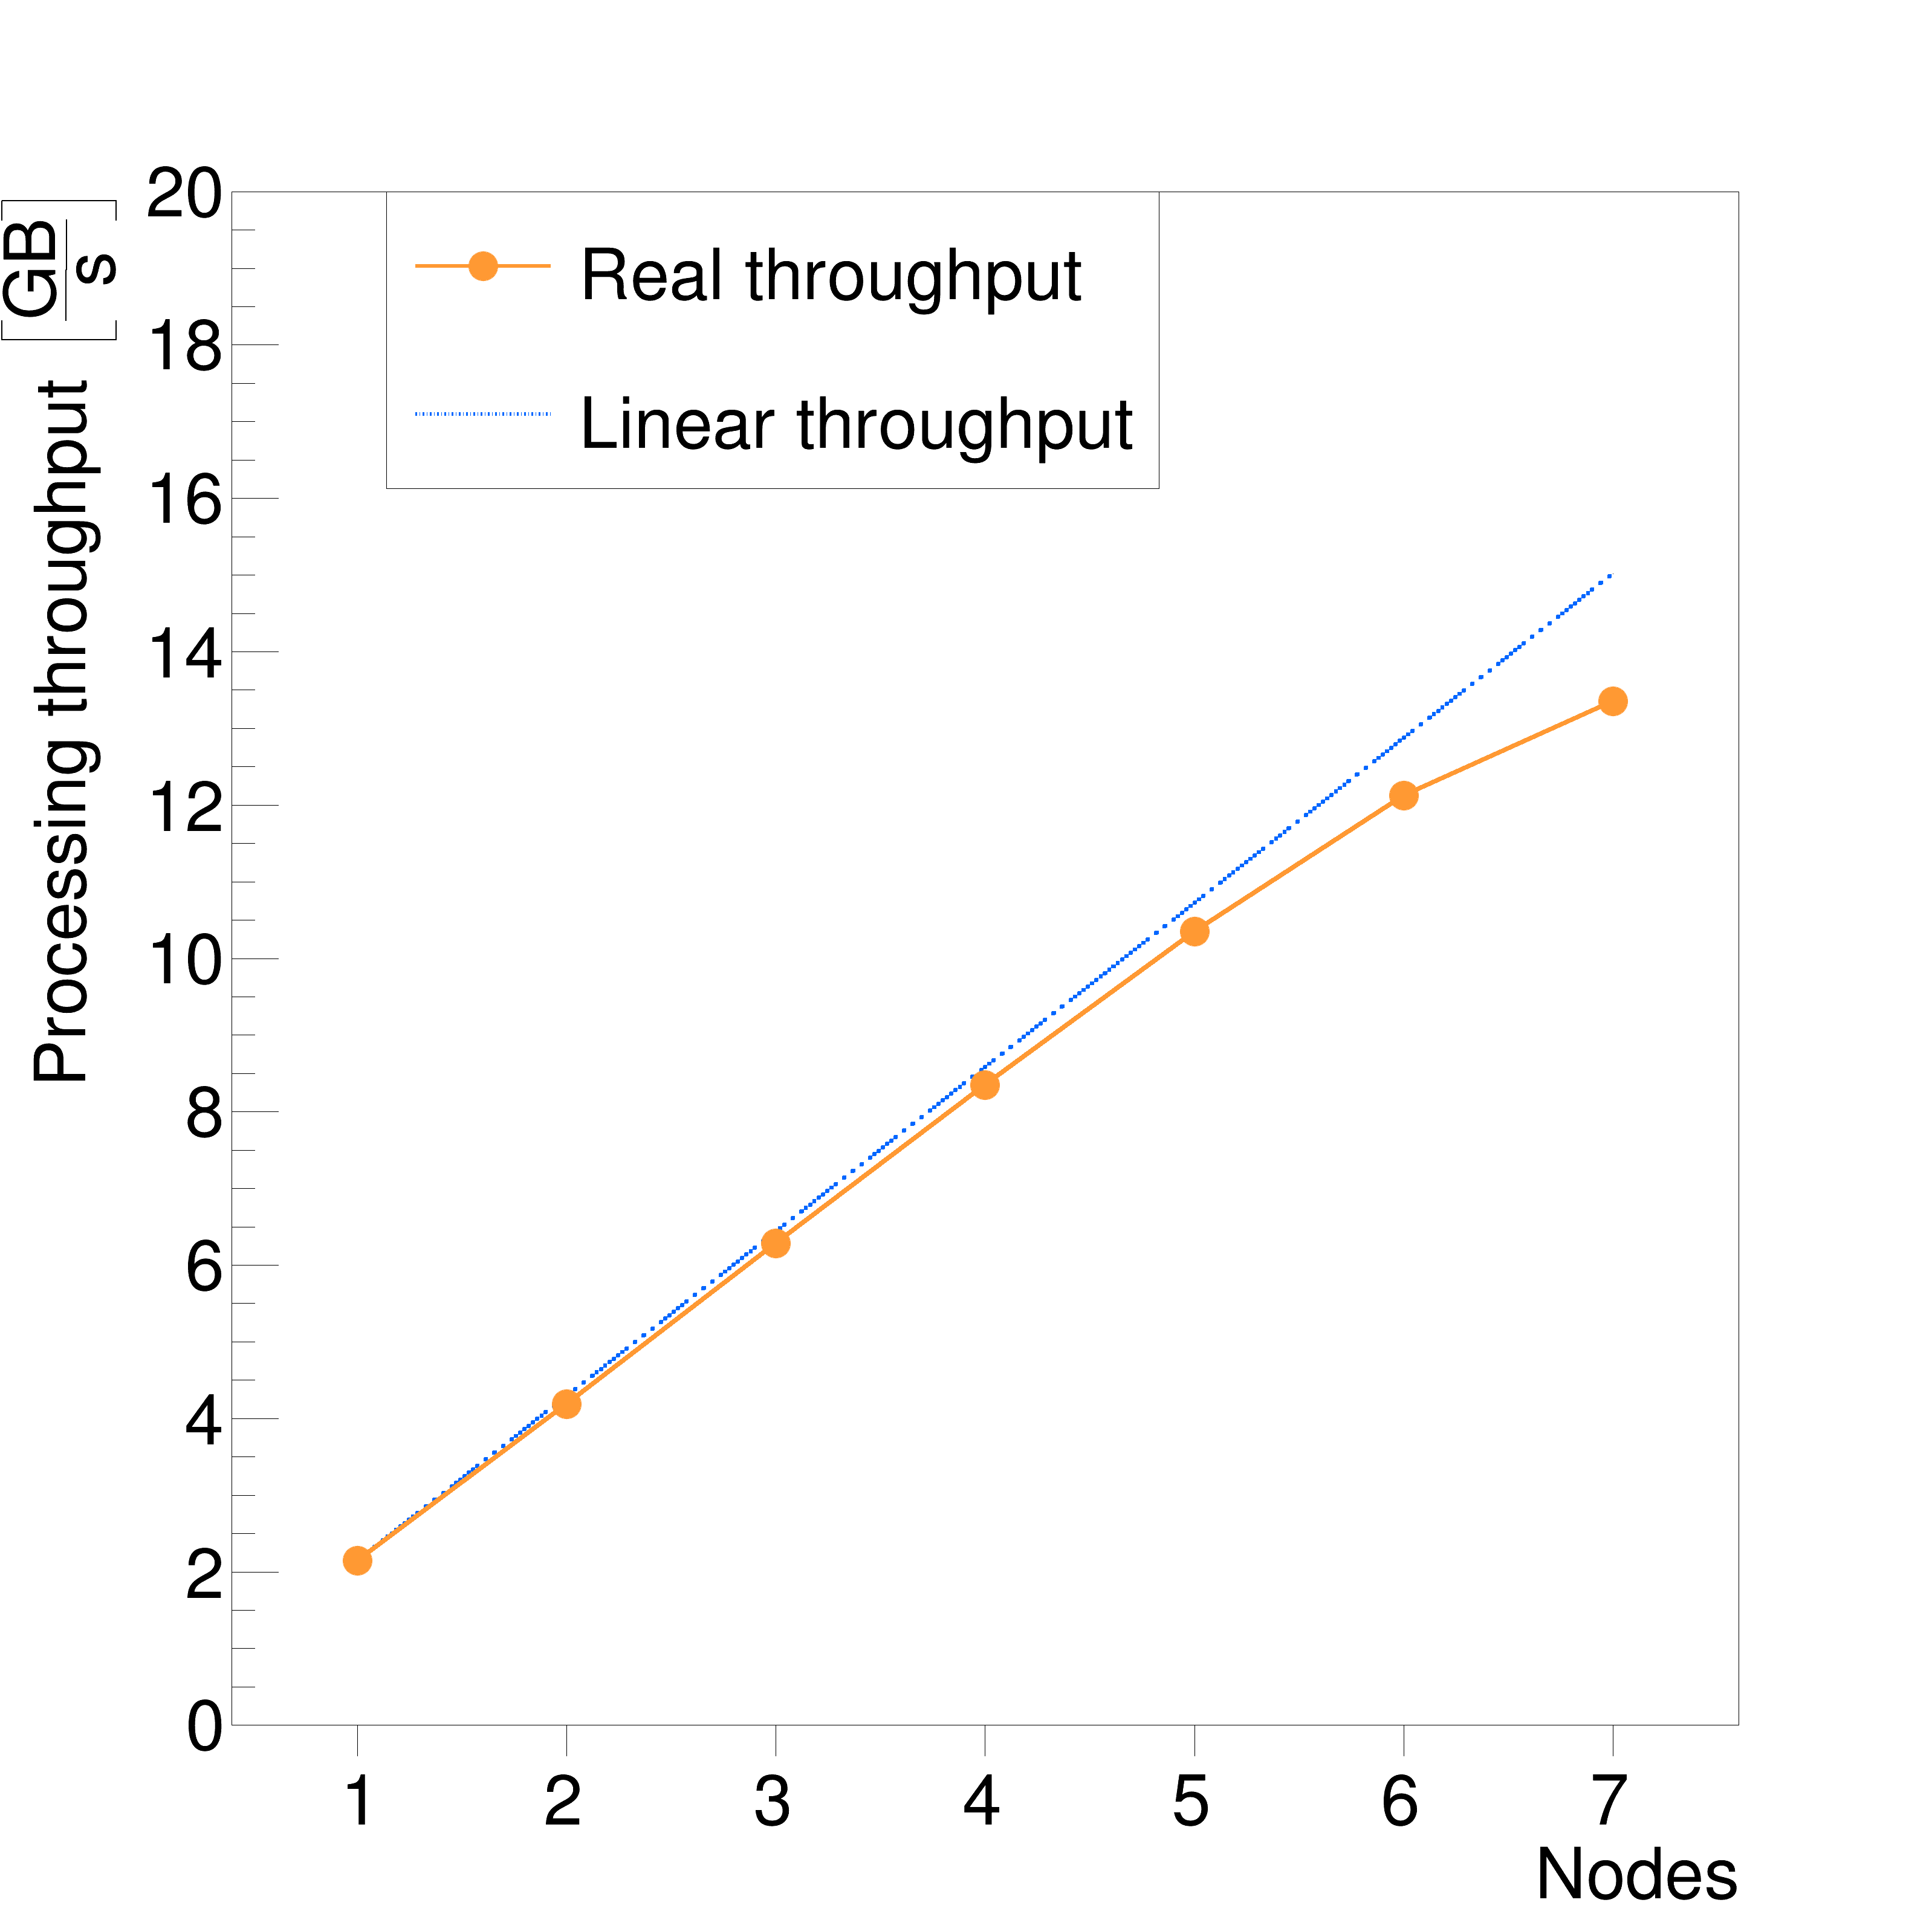

In [4]:
initialthroughput = timesdf["throughput_GB_s"][0]
linthroughput = numpy.array(timesdf["nodes"], dtype=float)
linthroughput = linthroughput * initialthroughput


lineargraph = ROOT.TGraph(len(timesdf["nodes"]),
                          numpy.array(timesdf["nodes"], dtype=float),
                          linthroughput)


realgraph = ROOT.TGraph(len(timesdf["nodes"]),
                        numpy.array(timesdf["nodes"], dtype=float),
                        numpy.array(timesdf["throughput_GB_s"], dtype=float))



width = 3200
height = 3200
d = ROOT.TCanvas("d", "", width, height)
d.SetLeftMargin(0.12)

lineargraph.SetTitle("")

lineargraph.GetXaxis().SetTitle("Nodes")
lineargraph.GetXaxis().SetTitleSize(0.04)
lineargraph.GetXaxis().SetTitleOffset(1.2)
lineargraph.GetXaxis().SetLabelSize(0)
lineargraph.GetXaxis().SetTickLength(0)

lineargraph.GetYaxis().SetTitle("Processing throughput #left[#frac{GB}{s}#right]")
lineargraph.GetYaxis().SetTitleOffset(1.4)
lineargraph.GetYaxis().SetLabelSize(0.04)
lineargraph.GetYaxis().SetTitleSize(0.04)
lineargraph.GetYaxis().SetRangeUser(0, 20)
#lineargraph.GetYaxis().SetNdivisions(12, 5, 0)


lineargraph.SetLineStyle(ROOT.kDashDotted)
lineargraph.SetLineColorAlpha(ROOT.kAzure-3,1)
lineargraph.SetLineWidth(6)
lineargraph.Draw("APL")

ymin = lineargraph.GetHistogram().GetMinimum()
ymax = lineargraph.GetHistogram().GetMaximum()

dy = ymax - ymin
labels = []
ticks = []

for i in range(len(timesdf["nodes"])):
    x = lineargraph.GetPointX(i)
    t = ROOT.TLatex(x-0.02, -1.3, str(int(x)))
    t.SetTextSize(0.04)
    t.SetTextFont(42)
    t.SetTextAlign(21)
    t.Draw()
    labels.append(t)
    l = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    l.Draw()
    ticks.append(l)


realgraph.SetMarkerStyle(20)
realgraph.SetMarkerSize(6)
realgraph.SetMarkerColor(ROOT.kOrange+1)

realgraph.SetLineColorAlpha(ROOT.kOrange+1,1)
realgraph.SetLineWidth(6)

realgraph.Draw("SAME PL")

legend = ROOT.TLegend(0.2,0.745,0.6,0.9)
legend.AddEntry(realgraph, "Real throughput")
legend.AddEntry(lineargraph, "Linear throughput", "L")
legend.Draw()
ROOT.gStyle.SetLegendTextSize(0.04)

d.Draw()
d.SaveAs("distrdf_lustre_lhcb_multinode_processingthroughput.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: d
Info in <TCanvas::Print>: png file distrdf_lustre_lhcb_multinode_processingthroughputspeedup.png has been created


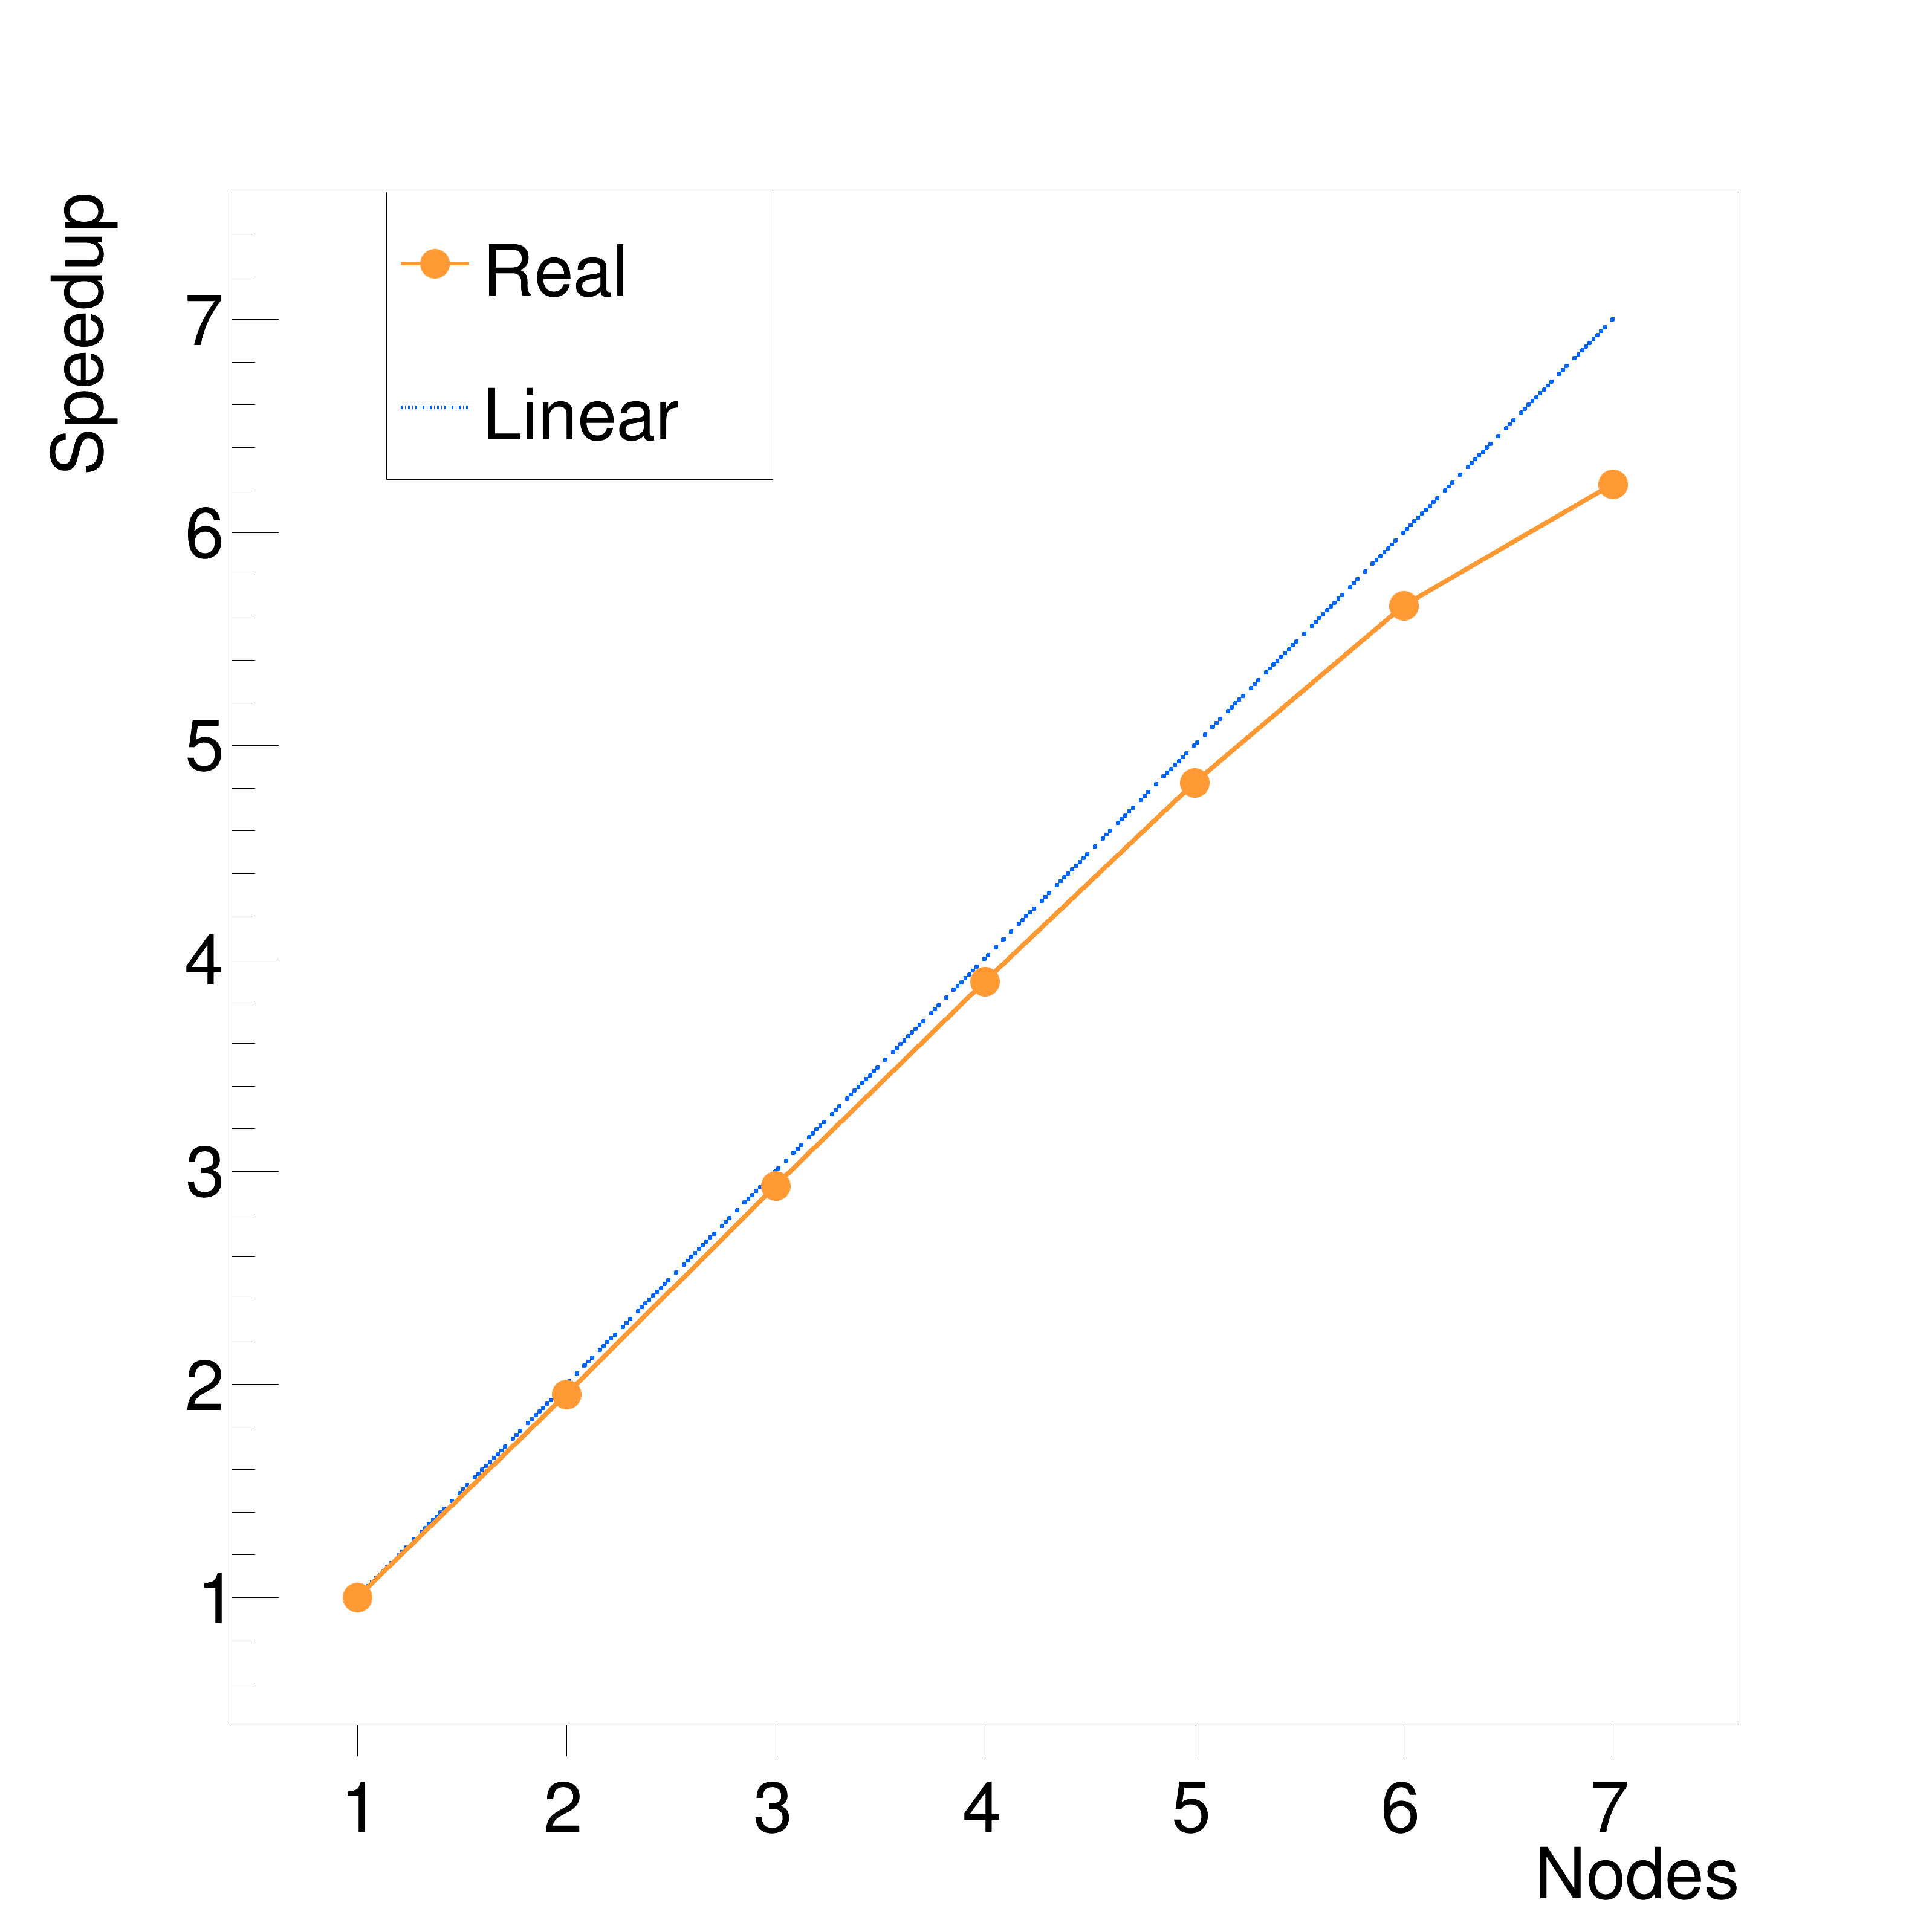

In [6]:
speedupgraph = ROOT.TGraph(len(timesdf["nodes"]),
                           numpy.array(timesdf["nodes"], dtype=float),
                           numpy.array(timesdf["throughput_speedup"], dtype=float))
idealspeedupgraph = ROOT.TGraph(len(timesdf["nodes"]),
                                numpy.array(timesdf["nodes"], dtype=float),
                                numpy.array(timesdf["nodes"], dtype=float))

width = 3200
height = 3200
c = ROOT.TCanvas("d", "", width, height)
c.SetLeftMargin(0.12)

idealspeedupgraph.SetTitle("")

idealspeedupgraph.GetXaxis().SetTitle("Nodes")
idealspeedupgraph.GetXaxis().SetTitleSize(0.04)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.2)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)
idealspeedupgraph.GetYaxis().SetTitle("Speedup")

idealspeedupgraph.GetYaxis().SetTitleSize(0.04)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.2)
idealspeedupgraph.GetYaxis().SetLabelSize(0.04)

idealspeedupgraph.SetMarkerColor(ROOT.kAzure-3)
idealspeedupgraph.SetLineStyle(ROOT.kDashDotted)
idealspeedupgraph.SetLineColorAlpha(ROOT.kAzure-3,1)
idealspeedupgraph.SetLineWidth(6)
idealspeedupgraph.Draw("AL")

ymin = idealspeedupgraph.GetHistogram().GetMinimum()
ymax = idealspeedupgraph.GetHistogram().GetMaximum()

dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(timesdf["nodes"])):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)

    xt = ROOT.TLatex(x-0.02, -0.1, str(int(x)))
    xt.SetTextSize(0.04)
    xt.SetTextFont(42)
    xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    xl.Draw()
    xticks.append(xl)

speedupgraph.SetMarkerStyle(20)
speedupgraph.SetMarkerSize(6)
speedupgraph.SetMarkerColor(ROOT.kOrange+1)

speedupgraph.SetLineColorAlpha(ROOT.kOrange+1,1)
speedupgraph.SetLineWidth(6)

speedupgraph.Draw("SAME PL")

legend = ROOT.TLegend(0.2,0.75,0.4,0.9)
legend.AddEntry(speedupgraph, "Real")
legend.AddEntry(idealspeedupgraph, "Linear", "L")
legend.Draw()
ROOT.gStyle.SetLegendTextSize(0.04)
c.Draw()
c.SaveAs("distrdf_lustre_lhcb_multinode_processingthroughputspeedup.png")